In [1]:
import os
import torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer,BartTokenizer, MBartForConditionalGeneration, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import pandas as pd
import numpy as np

In [2]:
model_name = "vinai/bartpho-syllable"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

In [3]:
data_files = {
    'train': 'data/train.csv',
    'validation': 'data/val.csv',
    'test': 'data/test.csv',
}
data = load_dataset("csv", data_files=data_files, split=None)

In [4]:
vism_data = load_dataset("csv", data_files="data/vism.csv", split="train")
vism_data = vism_data.filter(lambda x: x["document"] is not None and x["summary"] is not None)


In [ ]:
print(vism_data[0]) 
print(vism_data.column_names)  

In [ ]:
print(data)

In [7]:
def sanitize_labels(labels):
    """
    Replace any invalid tokens (like -100) in the labels with the pad token ID.
    """
    sanitized_labels = []
    for label in labels:
        if isinstance(label, list):
            sanitized_labels.append([
                tokenizer.pad_token_id if not isinstance(token, int) or token < 0 else token
                for token in label
            ])
        else:
            sanitized_labels.append([tokenizer.pad_token_id])  # Default to pad if format is unexpected
    return sanitized_labels

In [8]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["document"], max_length=512, truncation=True, padding="max_length")
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
tokenized_data = data.map(preprocess_function, batched=True)

tokenized_vism_data = vism_data.map(preprocess_function, batched=True)

tokenized_data = DatasetDict({
    "train": tokenized_data["train"],
    "validation": tokenized_data["validation"],
    "test": tokenized_data["test"],
    "vism": tokenized_vism_data
})


In [9]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [10]:
from evaluate import load
rouge = load("rouge")

In [11]:
def sanitize_labels(labels):
    sanitized_labels = []
    vocab_size = len(tokenizer)  # Total vocabulary size for the tokenizer

    for label in labels:
        # Ensure label is a list of integers within valid token ID range
        if isinstance(label, list):
            sanitized_labels.append([
                tokenizer.pad_token_id if not isinstance(token, int) or token < 0 or token >= vocab_size else token
                for token in label
            ])
        else:
            print(f"Warning: Unexpected label format {label}, expected list of integers.")
            sanitized_labels.append([tokenizer.pad_token_id])  # Use pad token for invalid formats
    return sanitized_labels

In [12]:
evaluation_results = {
    "epoch": [],
    "rouge1": [],
    "rouge2": [],
    "rougeL": [],
    "rougeLsum": [],
    "train_loss": [],
    "val_loss": []
}

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    preds = sanitize_labels(preds.tolist() if isinstance(preds, np.ndarray) else preds)
    labels = sanitize_labels(labels.tolist() if isinstance(labels, np.ndarray) else labels)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    
    current_epoch = len(evaluation_results["epoch"]) + 1
    evaluation_results["epoch"].append(current_epoch)
    evaluation_results["rouge1"].append(float(result["rouge1"]) * 100)
    evaluation_results["rouge2"].append(float(result["rouge2"]) * 100)
    evaluation_results["rougeL"].append(float(result["rougeL"]) * 100)
    evaluation_results["rougeLsum"].append(float(result["rougeLsum"]) * 100)

    return {
        "rouge1": float(result["rouge1"]) * 100,
        "rouge2": float(result["rouge2"]) * 100,
        "rougeL": float(result["rougeL"]) * 100,
        "rougeLsum": float(result["rougeLsum"]) * 100
    }

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./bartpho-summarization",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,  
    metric_for_best_model="rougeL",  
    greater_is_better=True,  
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    num_train_epochs=10,  
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=3e-5,
    predict_with_generate=True,
    generation_max_length=128,
    fp16=torch.cuda.is_available(),
    report_to="tensorboard",
)


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [15]:
def check_for_invalid_tokens(data):
    for example in data:
        if -100 in example['labels']:
            print("Invalid token -100 found in labels.")
            break

check_for_invalid_tokens(tokenized_data['train'])
check_for_invalid_tokens(tokenized_data['validation'])
check_for_invalid_tokens(tokenized_data['vism'])

In [16]:
# torch.cuda.empty_cache()

In [17]:
# trainer.train()
# torch.cuda.empty_cache()

In [18]:
# trainer.train(resume_from_checkpoint=True)

In [19]:
# model.save_pretrained("bartpho")
# tokenizer.save_pretrained("bartpho")

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
df_results = pd.read_csv("epoch_15.csv")
df_results

,Unnamed: 0,epoch,training_loss,eval_loss,rouge1,rouge2,rouge3,rougeLsum
0,0,1.0,1.0787,0.877216,74.829456,44.973022,46.165702,46.164766
1,1,2.0,0.7998,0.730443,75.600951,47.239103,48.479499,48.493848
2,2,3.0,0.6054,0.628908,76.678225,49.173543,50.185492,50.173284
3,3,4.0,0.4284,0.552659,77.589669,51.384143,52.147340,52.151762
4,4,5.0,0.3201,0.494950,78.755340,53.962160,54.713982,54.704661
5,5,6.0,0.2392,0.464704,79.643065,56.362009,57.428371,57.410200
6,6,7.0,0.1791,0.431135,80.774208,59.051530,60.326740,60.294599
7,7,8.0,0.1360,0.406767,82.677785,63.697542,65.002496,64.985913
8,8,9.0,0.1079,0.399185,83.505274,66.013271,67.341393,67.317099
9,9,10.0,0.0841,0.391010,84.966082,68.770453,70.049454,70.043408


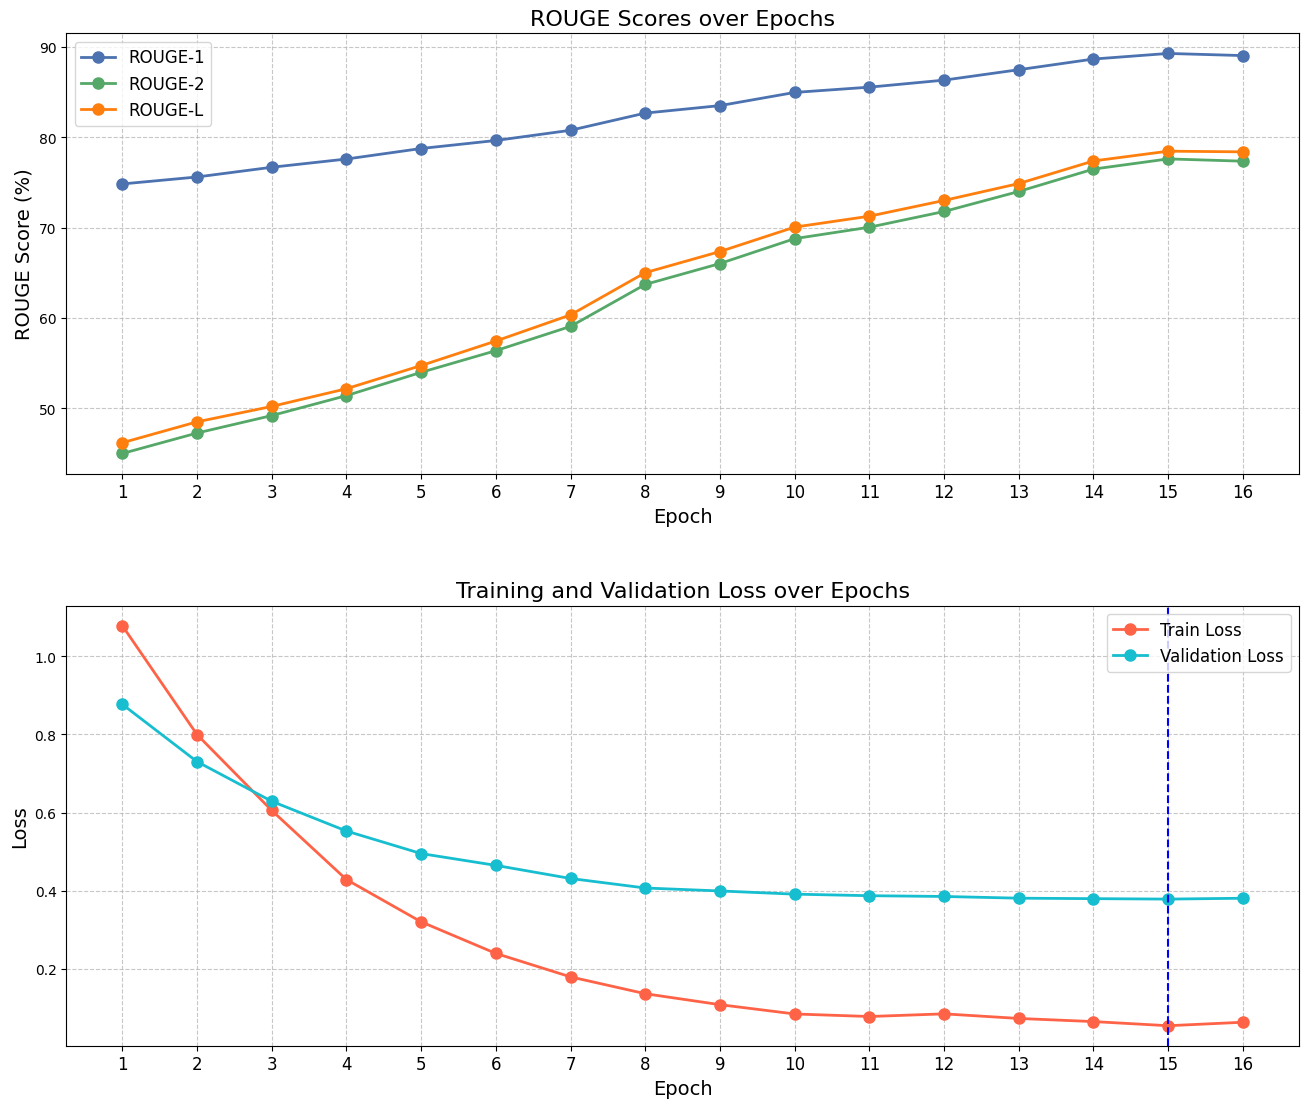

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 12))

plt.subplot(2, 1, 1)
plt.plot(df_results['epoch'], df_results['rouge1'], marker='o', markersize=8, linestyle='-', color='#4c72b0', label="ROUGE-1", linewidth=2)
plt.plot(df_results['epoch'], df_results['rouge2'], marker='o', markersize=8, linestyle='-', color='#55a868', label="ROUGE-2", linewidth=2)
plt.plot(df_results['epoch'], df_results['rouge3'], marker='o', markersize=8, linestyle='-', color='#ff7f0e', label="ROUGE-L", linewidth=2)

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("ROUGE Score (%)", fontsize=14)
plt.title("ROUGE Scores over Epochs", fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(df_results['epoch'], ha='center', fontsize=12)

plt.subplot(2, 1, 2)
plt.plot(df_results['epoch'], df_results['training_loss'], marker='o', markersize=8, linestyle='-', color='#ff6347', label="Train Loss", linewidth=2)
plt.plot(df_results['epoch'], df_results['eval_loss'], marker='o', markersize=8, linestyle='-', color='#17becf', label="Validation Loss", linewidth=2)

for i in range(1, len(df_results['eval_loss'])):
    if df_results['eval_loss'][i] > df_results['eval_loss'][i-1]:
        plt.axvline(x=df_results['epoch'][i-1], color='blue', linestyle='--', label="Increase Point (Validation Loss)" if i == 1 else "")
        break 

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training and Validation Loss over Epochs", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(df_results['epoch'], ha='center', fontsize=12)
plt.tight_layout(pad=4.0)

plt.show()


### Đọc viasm

In [22]:
# import os
# pathfiles =[]

# original_dir = os.path.expanduser("data/original")

# for cluster in os.listdir(original_dir):
#     cluster_path = os.path.join(original_dir, cluster, "original")
#     if os.path.isdir(cluster_path):
#         for root, _, files in os.walk(cluster_path):
#             for file in files:
#                 full_path = os.path.join(root, file)
#                 pathfiles.append(full_path)

#     print(pathfiles)


In [23]:
# import pandas as pd
# import chardet

# def read_content_from_pathfile(pathfile):
#     try:
#         with open(pathfile, "rb") as f:
#             raw_data = f.read()
#             result = chardet.detect(raw_data)
#             encoding = result['encoding'] if result['encoding'] else 'utf-8'

#         with open(pathfile, "r", encoding=encoding, errors="ignore") as f:
#             rows = f.readlines()
        
#         title = ''
#         summary = ''
#         content = ''
#         start_content = False

#         for row in rows:
#             row = row.strip() 

#             # Phân tích title
#             if row.startswith("Title:"):
#                 title = row[len("Title:"):].strip()

#             elif row.startswith("Summary:"):
#                 summary = row[len("Summary:"):].strip()

#             elif row.startswith("Content:"):
#                 start_content = True

#             elif start_content:
#                 content += row + " "

#         title = title.strip()
#         summary = summary.strip()
#         content = content.strip()

#         return {'document': content,'summary': summary}
#     except Exception as e:
#         print(f"Lỗi khi đọc file: {pathfile}. Chi tiết lỗi: {e}")
#         return {'file': pathfile, 'title': None, 'summary': None, 'content': None}


# data = [read_content_from_pathfile(pathfile) for pathfile in pathfiles]

# df = pd.DataFrame(data)
# df.dropna()

# df.to_csv("data/vism.csv", index = False)


### eval

In [24]:
# import os
# import json
# import pandas as pd
# from transformers import Seq2SeqTrainer, AutoTokenizer, AutoModelForSeq2SeqLM

# def evaluate_and_compare(model_path, test_data, vism_data, tokenizer, model_name="Model", max_length=512, cache_file="evaluation_results.json"):
#     if os.path.exists(cache_file):
#         with open(cache_file, "r") as f:
#             cached_results = json.load(f)
#     else:
#         cached_results = {}

#     if model_name in cached_results:
#         print(f"Skipping evaluation for {model_name} - results already cached.")
#         return cached_results[model_name]

#     print(f"\nEvaluating {model_name}...")

#     try:
#         model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")
#     except Exception as e:
#         print(f"Error loading model {model_name}: {e}")
#         return None

#     results = {}

#     # Đánh giá trên tập Test
#     print("\nEvaluating on Test dataset...")
#     try:
#         test_trainer = Seq2SeqTrainer(
#             model=model,
#             args=training_args,
#             eval_dataset=test_data,
#             tokenizer=tokenizer,
#             data_collator=data_collator,
#             compute_metrics=compute_metrics,
#         )
#         results["test"] = test_trainer.evaluate()
#         print(f"Results on Test dataset: {results['test']}")
#     except Exception as e:
#         print(f"Error evaluating on Test dataset for {model_name}: {e}")

#     print("\nEvaluating on Vism dataset...")
#     try:
#         vism_trainer = Seq2SeqTrainer(
#             model=model,
#             args=training_args,
#             eval_dataset=vism_data,
#             tokenizer=tokenizer,
#             data_collator=data_collator,
#             compute_metrics=compute_metrics,
#         )
#         results["vism"] = vism_trainer.evaluate()
#         print(f"Results on Vism dataset: {results['vism']}")
#     except Exception as e:
#         print(f"Error evaluating on Vism dataset for {model_name}: {e}")

#     cached_results[model_name] = results
#     with open(cache_file, "w") as f:
#         json.dump(cached_results, f, indent=4)

#     return results


# print("\nEvaluating Original Pretrained Model...")
# original_results = evaluate_and_compare(
#     model_path=model_name, 
#     test_data=tokenized_data["test"],
#     vism_data=tokenized_data["vism"],
#     tokenizer=tokenizer,
#     model_name="Original Pretrained Model",
#     cache_file="evaluation_results.json"
# )

# checkpoint_path = "ep15_0009 checkpoint-11310"
# print("\nEvaluating Checkpoint Model...")
# checkpoint_results = evaluate_and_compare(
#     model_path=checkpoint_path,
#     test_data=tokenized_data["test"],
#     vism_data=tokenized_data["vism"],
#     tokenizer=tokenizer,
#     model_name="Checkpoint Model",
#     cache_file="evaluation_results.json"
# )

# models = {
#     "mT5": {
#         "path": "google/mt5-small",
#         "max_length": 512
#     },
#     "mBART": {
#         "path": "facebook/mbart-large-50",
#         "max_length": 1024
#     },
#     "Pegasus": {
#         "path": "google/pegasus-xsum",
#         "max_length": 1024
#     }
# }

# additional_results = []

# for model_name, model_info in models.items():
#     model_path = model_info["path"]
#     max_length = model_info["max_length"]

#     try:
#         tokenizer = AutoTokenizer.from_pretrained(model_path)
#         tokenizer.model_max_length = max_length
#         tokenizer.pad_token = tokenizer.eos_token  

#         model_results = evaluate_and_compare(
#             model_path=model_path,
#             test_data=tokenized_data["test"],
#             vism_data=tokenized_data["vism"],
#             tokenizer=tokenizer,
#             model_name=model_name,
#             max_length=max_length,
#             cache_file="evaluation_results.json"
#         )
#         if model_results:
#             additional_results.append((model_name, model_results))
#     except Exception as e:
#         print(f"Error with model {model_name}: {e}")

# comparison_data = []

# comparison_data.append({"Model": "Original", "Dataset": "Test", **original_results["test"]})
# comparison_data.append({"Model": "Original", "Dataset": "Vism", **original_results["vism"]})
# comparison_data.append({"Model": "Checkpoint", "Dataset": "Test", **checkpoint_results["test"]})
# comparison_data.append({"Model": "Checkpoint", "Dataset": "Vism", **checkpoint_results["vism"]})

# for model_name, model_results in additional_results:
#     if model_results:
#         comparison_data.append({"Model": model_name, "Dataset": "Test", **model_results["test"]})
#         comparison_data.append({"Model": model_name, "Dataset": "Vism", **model_results["vism"]})

# df_comparison = pd.DataFrame(comparison_data)
# print("\n--- Comparison Results ---")
# print(df_comparison)

# df_comparison.to_csv("model_comparison_results.csv", index=False)


In [25]:
from datasets import load_dataset

vmss = load_dataset("leduckhai/VietMed-Sum")
oph = load_dataset("OpenHust/vietnamese-summarization")
hll = load_dataset("HaiLong9901/VietNameseLongTextSum")

In [ ]:
hl = hll['test']
hl

In [ ]:
vms = vmss["test.en_test_full_dialogue_asr"]
vms

In [ ]:
oph = load_dataset("OpenHust/vietnamese-summarization", split="train")
oph = oph.select(range(1000))
print(oph)


In [ ]:
from datasets import Dataset, DatasetDict

def clean_and_rename_columns(dataset, dataset_name):
    if dataset_name == "hl":
        dataset = dataset.rename_column("article", "document")
        dataset = dataset.rename_column("abstract", "summary")
        dataset = dataset.remove_columns(["section_names"])

    elif dataset_name == "vms":
        dataset = dataset.rename_column("transcript", "document")

    elif dataset_name == "oph":
        dataset = dataset.rename_column("Document", "document")
        dataset = dataset.rename_column("Summary", "summary")
        dataset = dataset.remove_columns(["Unnamed: 0", "Dataset"])

    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    return dataset

def preprocess_function(examples, dataset_name):
    if dataset_name == "vms":
        document_column = "document"
        summary_column = "summary"
    elif dataset_name == "hl":
        document_column = "document"
        summary_column = "summary"
    elif dataset_name == "oph":
        document_column = "document"
        summary_column = "summary"
    else:
        raise ValueError("Unknown dataset name")

    model_inputs = tokenizer(examples[document_column], max_length=512, truncation=True, padding="max_length")
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples[summary_column], max_length=128, truncation=True, padding="max_length")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

cleaned_data = {
    "hl": clean_and_rename_columns(hl, "hl"),
    "vms": clean_and_rename_columns(vms, "vms"),
    "oph": clean_and_rename_columns(oph, "oph")
}

tokenized_data = {
    "hl": cleaned_data["hl"].map(lambda examples: preprocess_function(examples, dataset_name="hl"), batched=True),
    "vms": cleaned_data["vms"].map(lambda examples: preprocess_function(examples, dataset_name="vms"), batched=True),
    "oph": cleaned_data["oph"].map(lambda examples: preprocess_function(examples, dataset_name="oph"), batched=True)
}

tokenized_data_dict = DatasetDict({
    "hl": tokenized_data["hl"],
    "vms": tokenized_data["vms"],
    "oph": tokenized_data["oph"]
})

print(tokenized_data_dict)


In [ ]:
import os
import json
import pandas as pd
from transformers import Seq2SeqTrainer, AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments

def evaluate_and_compare(model_path, hl_data, vms_data, oph_data, tokenizer, model_name, max_length=512, cache_file="evaluation_results.json"):
    if os.path.exists(cache_file):
        with open(cache_file, "r") as f:
            cached_results = json.load(f)
    else:
        cached_results = {}

    if model_name in cached_results:
        all_cached = True
        for dataset_name in ["hl", "vms", "oph"]:
            if dataset_name not in cached_results[model_name]:
                all_cached = False
                break
        
        if all_cached:
            print(f"Skipping evaluation for {model_name} - results for all datasets already cached.")
            return cached_results[model_name]

    print(f"\nEvaluating {model_name}...")

    try:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")
    except Exception as e:
        print(f"Error loading model {model_name}: {e}")
        return None

    results = {}

    print("\nEvaluating on HL dataset...")
    try:
        hl_trainer = Seq2SeqTrainer(
            model=model,
            args=training_args,
            eval_dataset=hl_data,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        results["hl"] = hl_trainer.evaluate()
        print(f"Results on HL dataset: {results['hl']}")
    except Exception as e:
        print(f"Error evaluating on HL dataset for {model_name}: {e}")

    print("\nEvaluating on VMS dataset...")
    try:
        vms_trainer = Seq2SeqTrainer(
            model=model,
            args=training_args,
            eval_dataset=vms_data,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        results["vms"] = vms_trainer.evaluate()
        print(f"Results on VMS dataset: {results['vms']}")
    except Exception as e:
        print(f"Error evaluating on VMS dataset for {model_name}: {e}")

    # Evaluate on oph dataset
    print("\nEvaluating on Oph dataset...")
    try:
        oph_trainer = Seq2SeqTrainer(
            model=model,
            args=training_args,
            eval_dataset=oph_data,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        results["oph"] = oph_trainer.evaluate()
        print(f"Results on Oph dataset: {results['oph']}")
    except Exception as e:
        print(f"Error evaluating on Oph dataset for {model_name}: {e}")

    cached_results[model_name] = results
    with open(cache_file, "w") as f:
        json.dump(cached_results, f, indent=4)

    return results


tokenized_data = {
    "hl": tokenized_data["hl"],  
    "vms": tokenized_data["vms"],  
    "oph": tokenized_data["oph"], 
}

tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")

print("\nEvaluating Original Pretrained Model...")
original_results = evaluate_and_compare(
    model_path="vinai/bartpho-syllable", 
    hl_data=tokenized_data["hl"],
    vms_data=tokenized_data["vms"],
    oph_data=tokenized_data["oph"],
    tokenizer=tokenizer,
    model_name="Original Pretrained Model",
    cache_file="evaluation_results.json"
)

checkpoint_path = "ep15_0009 checkpoint-11310"
print("\nEvaluating Checkpoint Model...")
checkpoint_results = evaluate_and_compare(
    model_path=checkpoint_path,
    hl_data=tokenized_data["hl"],
    vms_data=tokenized_data["vms"],
    oph_data=tokenized_data["oph"],
    tokenizer=tokenizer,
    model_name="Checkpoint Model",
    cache_file="evaluation_results.json"
)

models = {
    "mT5": {
        "path": "google/mt5-small",
        "max_length": 512
    },
    "mBART": {
        "path": "facebook/mbart-large-50",
        "max_length": 1024
    },
    "Pegasus": {
        "path": "google/pegasus-xsum",
        "max_length": 1024
    }
}

additional_results = []

for model_name, model_info in models.items():
    model_path = model_info["path"]
    max_length = model_info["max_length"]

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        tokenizer.model_max_length = max_length
        tokenizer.pad_token = tokenizer.eos_token  

        model_results = evaluate_and_compare(
            model_path=model_path,
            hl_data=tokenized_data["hl"],
            vms_data=tokenized_data["vms"],
            oph_data=tokenized_data["oph"],
            tokenizer=tokenizer,
            model_name=model_name,
            max_length=max_length,
            cache_file="evaluation_results.json"
        )
        if model_results:
            additional_results.append((model_name, model_results))
    except Exception as e:
        print(f"Error with model {model_name}: {e}")

comparison_data = []

comparison_data.append({"Model": "Original", "Dataset": "HL", **original_results["hl"]})
comparison_data.append({"Model": "Original", "Dataset": "VMS", **original_results["vms"]})
comparison_data.append({"Model": "Original", "Dataset": "Oph", **original_results["oph"]})

comparison_data.append({"Model": "Checkpoint", "Dataset": "HL", **checkpoint_results["hl"]})
comparison_data.append({"Model": "Checkpoint", "Dataset": "VMS", **checkpoint_results["vms"]})
comparison_data.append({"Model": "Checkpoint", "Dataset": "Oph", **checkpoint_results["oph"]})

for model_name, model_results in additional_results:
    if model_results:
        comparison_data.append({"Model": model_name, "Dataset": "HL", **model_results["hl"]})
        comparison_data.append({"Model": model_name, "Dataset": "VMS", **model_results["vms"]})
        comparison_data.append({"Model": model_name, "Dataset": "Oph", **model_results["oph"]})

df_comparison = pd.DataFrame(comparison_data)
print("\n--- Comparison Results ---")
print(df_comparison)

df_comparison.to_csv("model_comparison_results.csv", index=False)


In [60]:

df_comparison["Model"] = df_comparison["Model"].replace({
    "Original": "BartPho",
    "Checkpoint": "BartPho - Tuned"
})

columns_to_keep = ["Model", "Dataset", "eval_loss", "eval_rouge1", "eval_rouge2", "eval_rougeL"]
df= df_comparison[columns_to_keep]
df

,Model,Dataset,eval_loss,eval_rouge1,eval_rouge2,eval_rougeL
0,BartPho,HL,11.470880,45.683775,18.300120,26.691266
1,BartPho,VMS,8.994923,25.032880,11.229186,21.056574
2,BartPho,Oph,12.803679,46.465426,22.777982,29.408258
3,BartPho - Tuned,HL,2.829698,44.154061,17.161899,25.974397
4,BartPho - Tuned,VMS,1.294039,21.179643,7.125619,17.184149
5,BartPho - Tuned,Oph,2.040961,44.703795,21.621397,28.028441
6,mT5,HL,28.624506,0.347760,0.000000,0.343686
7,mT5,VMS,25.432442,1.034727,0.026192,1.025744
8,mT5,Oph,28.643410,0.293860,0.000000,0.293543
9,mBART,HL,10.983855,18.333328,4.257590,11.928546


In [61]:
df_comparison = pd.read_csv("model_comparison_results0.csv")

df_comparison["Model"] = df_comparison["Model"].replace({
    "Original": "BartPho",
    "Checkpoint": "BartPho - Tuned"
})

columns_to_keep = ["Model", "Dataset", "eval_loss", "eval_rouge1", "eval_rouge2", "eval_rougeL"]
df= df_comparison[columns_to_keep]
df

,Model,Dataset,eval_loss,eval_rouge1,eval_rouge2,eval_rougeL
0,BartPho,Test,4.027569,69.537566,35.593201,38.699104
1,BartPho,Vism,11.633308,44.463605,22.386511,28.728516
2,BartPho - Tuned,Test,0.386875,88.789228,76.638213,78.025244
3,BartPho - Tuned,Vism,1.812296,45.695814,22.023355,28.312054
4,mT5,Test,31.352608,0.132067,0.002707,0.132836
5,mT5,Vism,27.864143,0.484201,0.000000,0.478302
6,mBART,Test,6.134651,36.674266,14.843693,25.246012
7,mBART,Vism,10.849071,21.585413,8.620721,15.912772
8,Pegasus,Test,10.078676,2.217169,0.000000,1.964518
9,Pegasus,Vism,4.391542,1.617105,0.002339,1.525964
